## Entrenamiento de modelo para entorno de producción

### Dependencias

In [19]:
import awswrangler as wr
import datetime
import mlflow
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix,
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
    ConfusionMatrixDisplay,
)

Variables de entorno:

In [ ]:
%env AWS_ACCESS_KEY_ID=minio   
%env AWS_SECRET_ACCESS_KEY=minio123 
%env MLFLOW_S3_ENDPOINT_URL=http://localhost:9000
%env AWS_ENDPOINT_URL_S3=http://localhost:9000

In [2]:
mlflow_server = "http://localhost:5000"

mlflow.set_tracking_uri(mlflow_server)

### Cargar datos de entrenamiento y evaluación
Cargar los datos de entrenamiento y evaluación guardados en el proceso de ETL en Apache Airflow en S3:

In [6]:
PREFIX_CSV_FILES = "healthcare-dataset-stroke-data_"
X_train =  wr.s3.read_csv(f"s3://data/final/train/{PREFIX_CSV_FILES}X_train.csv")
y_train =  wr.s3.read_csv(f"s3://data/final/train/{PREFIX_CSV_FILES}y_train.csv")

X_test =  wr.s3.read_csv(f"s3://data/final/test/{PREFIX_CSV_FILES}X_test.csv")
y_test =  wr.s3.read_csv(f"s3://data/final/test/{PREFIX_CSV_FILES}y_test.csv")

### Entrenamiento del modelo para producción
Creación del experimento en MLflow con el entrenamiento del modelo:

In [20]:
experiment = mlflow.get_experiment_by_name("Stroke Prediction")
if not experiment:
    experiment_id = mlflow.create_experiment("Stroke Prediction")
else:
    experiment_id = experiment.experiment_id
print(experiment_id)
run_name_parent = "stroke_prediction_train_"  + datetime.datetime.today().strftime('%Y/%m/%d-%H:%M:%S"')

2


Entrenamiento del modelo con Scikit-learn:

Accuracy: 0.9718085106382979
Precision: 0.9703075291622482
Recall: 0.973404255319149
f1 score: 0.971853425385024


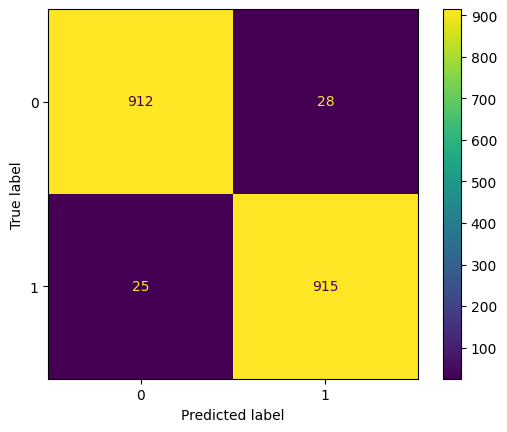

In [22]:
model_params = {"n_estimators": 20, "criterion": "log_loss", "max_depth": 50}
model = RandomForestClassifier(**model_params)
model.fit(X_train, y_train.to_numpy().ravel())
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1_value = f1_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("f1 score:", f1_value)
disp = ConfusionMatrixDisplay(confusion)
disp.plot()

Registro de entrenamiento en MLflow:

In [25]:
import mlflow.models


with mlflow.start_run(experiment_id=experiment_id, run_name=run_name_parent, nested=True):
    mlflow.set_tags(tags={"project": "Stroke Prediction", "model_family": "sklearn", "feature_set_version": 1})
    mlflow.log_params(model_params)
    mlflow.log_metric("f1_score", f1_value)
    mlflow.log_figure(figure=disp.figure_, artifact_file="confusion_matrix.png")
    signature = mlflow.models.infer_signature(X_train, model.predict(X_train))

    mlflow.sklearn.log_model(
        sk_model=model,
        artifact_path="model",
        signature=signature,
        serialization_format='cloudpickle',
        registered_model_name="stroke_prediction_model_dev",
        metadata={"model_data_version": 1}
    )

    model_uri = mlflow.get_artifact_uri("model")


Successfully registered model 'stroke_prediction_model_dev'.
2024/12/11 22:48:34 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: stroke_prediction_model_dev, version 1
Created version '1' of model 'stroke_prediction_model_dev'.


🏃 View run stroke_prediction_train_2024/12/11-22:36:29" at: http://localhost:5000/#/experiments/2/runs/c1cb203d0ea9438d96750ef724084de9
🧪 View experiment at: http://localhost:5000/#/experiments/2


### Registro del modelo para producción
El modelo puede observarse en la siguiente URL: http://localhost:5000/#/models

In [26]:
client = mlflow.MlflowClient()
name = "stroke_prediction_model_prod"
description = "This model is used to predict whether a patient is likely to get stroke \
based on the input parameters like gender, age, various diseases, and smoking status."

client.create_registered_model(name=name, description=description)
tags = model.get_params()
tags["model"] = type(model).__name__
tags["f1-score"] = f1_value

result = client.create_model_version(name=name, source=model_uri, run_id=model_uri.split("/")[-3], tags=tags)

# alias to use model in retrain model airflow service
client.set_registered_model_alias(name, "champion", result.version)

2024/12/11 22:54:06 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: stroke_prediction_model_prod, version 1
